In [1]:
# LOAD PACKAGES
from scipy.spatial.transform import Rotation as R
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore')
from matplotlib.lines import Line2D
from scipy.signal import butter, filtfilt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# LOAD THE DATA
df_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

In [3]:
# Convert timestamp from string to datetime
df_raw['datetime_txt'] = df_raw['Date'] + " " + df_raw['Time hh:mm:ss.ddd']
df_raw['datetime'] = pd.to_datetime(df_raw['datetime_txt'], format = '%d/%m/%Y %H:%M:%S.%f')

gps['datetime_txt'] = gps['Date'] + " " + gps['Time']
gps['datetime'] = pd.to_datetime(gps['datetime_txt'], format = '%d/%m/%Y %H:%M:%S')

In [4]:
# Select Columns
df_raw = df_raw[['Acc_x',
        'Acc_y',
        'Acc_z',
        'Mag_x',
        'Mag_y',
        'Mag_z',
        'datetime']]

In [5]:
# Merge GPS and activity data
df_raw = pd.merge(df_raw, gps, on='datetime', how='left')

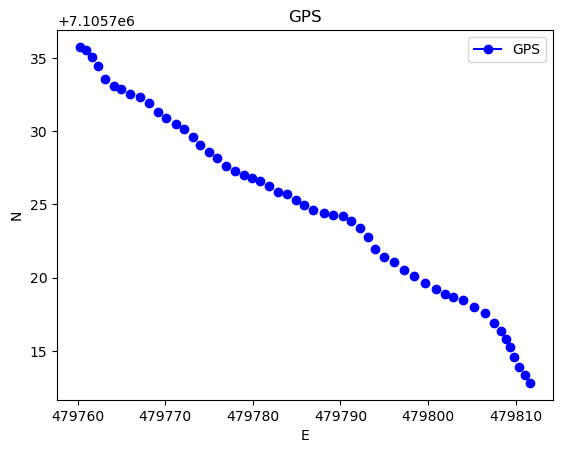

In [6]:
# PLOT GPS OVER TIME
start = 250
end = 800
x = df_raw['UTM_E'].iloc[start:end]
y = df_raw['UTM_N'].iloc[start:end]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(x, y, marker='o', linestyle='-', color='b', label='GPS')

# Setting labels
ax.set_xlabel('E')
ax.set_ylabel('N')

# Adding a title and legend
ax.set_title('GPS')
ax.legend()

# Show plot
plt.show()

In [34]:
df_copy = df_raw.iloc[start:end].copy()
pts = df_copy[df_copy['UTM_E'].notnull()]
a = pts['UTM_E'].iloc[0] - pts['UTM_E'].iloc[-1]
b = pts['UTM_N'].iloc[-1] - pts['UTM_N'].iloc[0]
math.sqrt((a**2 + b**2))

56.386725003463425

In [33]:
a

1959.7062005629996

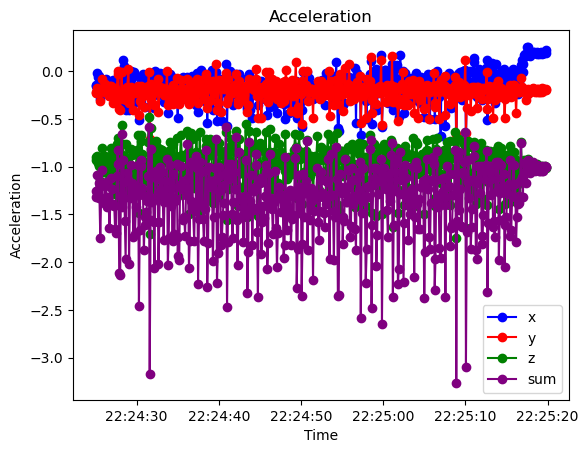

In [9]:
# PLOT ACCELERATION OVER TIME
Acc_x = df_raw['Acc_x'].iloc[start:end]
Acc_y = df_raw['Acc_y'].iloc[start:end]
Acc_z = df_raw['Acc_z'].iloc[start:end]
dt = df_raw['datetime'].iloc[start:end]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_x, marker='o', linestyle='-', color='b', label='x')
ax.plot(dt, Acc_y, marker='o', linestyle='-', color='r', label='y')
ax.plot(dt, Acc_z, marker='o', linestyle='-', color='g', label='z')
ax.plot(dt, Acc_x+Acc_y+Acc_z,marker='o', linestyle='-', color='purple', label='sum')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Acceleration')
ax.legend()

# Show plot
plt.show()

In [10]:
df = df_raw.copy().iloc[start:end].reset_index()

## 1) Remove effects of pitch and roll

Static acceleration is estimated using a 4th order zero phase low pass butterworth filter with wc = 0.1 Hz following Ladha et al. 2018 (BMC Veterinary Research). 

In [11]:
# DESIGN THE BUTTERWORTH FILTER

# Parameters
order = 4  # 4th order
cutoff_frequency = 0.1  # Cutoff frequency in Hz
sampling_rate = 1.0  # Sampling rate in Hz (adjust as needed)

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [12]:
# APPLY THE FILTER TO CALCULATE STATIC ACCELERATION

df['Gx'] = filtfilt(b, a, df['Acc_x'])
df['Gy'] = filtfilt(b, a, df['Acc_y'])
df['Gz'] = filtfilt(b, a, df['Acc_z'])

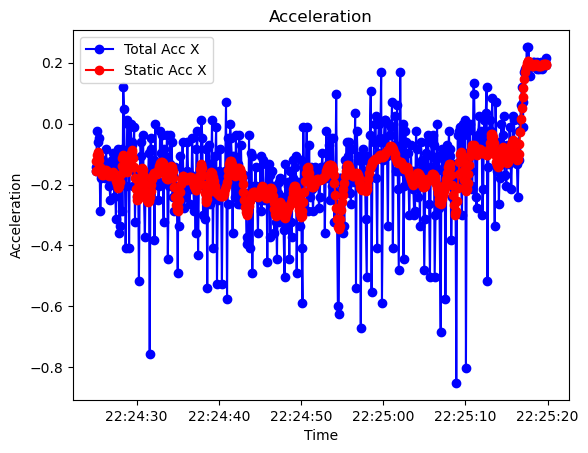

In [13]:
# PLOT STATIC ACCLERATION
Acc_x = df['Acc_x']
Gx = df['Gx']
dt = df['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_x, marker='o', linestyle='-', color='b', label='Total Acc X')
ax.plot(dt, Gx, marker='o', linestyle='-', color='r', label='Static Acc X')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Acceleration')
ax.legend()

# Show plot
plt.show()

In [14]:
# COMPUTE PITCH

# Function to compute roll
def calculate_pitch(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    pitch = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(pitch)

# Compute roll
df['pitch']=df.apply(calculate_pitch,axis=1)


In [15]:
# COMPUTE ROLL

# Function to compute roll
def calculate_roll(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    roll = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(roll)

# Compute roll
df['roll']=df.apply(calculate_roll,axis=1)

In [16]:
# ROTATE DATA

# Build rotation function
def rotate_data(row):
    pitch = row['pitch']
    roll = row['roll']
    Rx = np.array([[1,0,0],
          [0,math.cos(pitch),math.sin(pitch)],
          [0,-math.sin(pitch),math.cos(pitch)]])
    Ry = np.array([[math.cos(roll),0,-math.sin(roll)],
         [0,1,0],
         [math.sin(roll),0,math.cos(roll)]])
    Ax = row['Acc_x']
    Ay = row['Acc_y']
    Az = row['Acc_z']
    A = np.array([[Ax],[Ay],[Az]])
    RA = Ry @ Rx @ A
    row['RAx'] = RA[0]
    row['RAy'] = RA[1]
    row['RAz'] = RA[2]
    return row

# Initialize columns
df['RAx'] = -999
df['RAy'] = -999
df['RAz'] = -999

# Rotate data
df = df.apply(rotate_data,axis=1)

## Identify candidate steps using dynamic threshold on filtered DV axis

In [17]:
# DESIGN THE BUTTERWORTH FILTER

# Parameters
order = 4  # 4th order
cutoff_frequency = 0.2  # Cutoff frequency in Hz
sampling_rate = 1.0  # Sampling rate in Hz (adjust as needed)

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [18]:
# APPLY THE FILTER TO ROTATED DATA

df['FRAx'] = filtfilt(b, a, df['RAx'])
df['FRAy'] = filtfilt(b, a, df['RAy'])
df['FRAz'] = filtfilt(b, a, df['RAz'])

In [19]:
# DERIVE ZERO THRESHOLD USIng 20s WINDOWS

# Set the timestamp as the index
df.set_index('datetime', drop = False, inplace = True) 

# Initialize zero threshold column
df['thresh_z'] = -999

# Initialize falling flank column
df['falling_edges'] = False

for window_start in df.resample('20S').groups:
    
    window_data = df.loc[window_start:window_start + pd.Timedelta(seconds=20)]
    print(f"Window starting at: {window_start}")

    # Identify mean of max peak and min nadir in each window for acc in z axis
    signal = window_data['FRAz'].values
    max_z = signal.max()
    min_z = signal.min()
    thresh = (max_z + min_z)/2
    window_data['thresh_z'] = thresh

    # Identify falling flanks that cross the zero threshold 
    
    falling_edges = (signal[:-1] > thresh) & (signal[1:] <= thresh)
    window_data['falling_edges'].iloc[1:] = falling_edges

    df.loc[window_start:window_start + pd.Timedelta(seconds=20)] = window_data
    

Window starting at: 2019-02-25 22:24:20
Window starting at: 2019-02-25 22:24:40
Window starting at: 2019-02-25 22:25:00


In [20]:
# PLOT ZERO THRESHOLD
# FRAx = df['FRAz'].iloc[0:100]
# thresh_x = df['thresh_z'].iloc[0:100]
# dt = df['datetime'].iloc[0:100]
# dt_falling_edges = df[df['falling_edges'] == True]['datetime'].iloc[0:16]
# falling_edges = df[df['falling_edges'] == True]['FRAz'].iloc[0:16]

# # Create a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111)

# # Plot the trajectory
# ax.plot(dt, thresh_x,  linestyle='-', color='r', label='Zero Threshold')
# ax.plot(dt, FRAx, marker = "o",linestyle='-', color='b', label='Rotated and Filtered Acc Z')
# ax.plot(dt_falling_edges, falling_edges, marker = "o",linestyle='', color='black', label='Falling Edge')

# # Setting labels
# ax.set_xlabel('Time')
# ax.set_ylabel('Acceleration')

# # Adding a title and legend
# ax.set_title('Acceleration')
# ax.legend()

# # Show plot
# plt.show()


## Reject candidate steps based on valid step frequency 

In [21]:
# VALID STEP FREQUENCIES
# Based on range of observed stride frequencies in Eland (a species of comparable body mass; stride frequency is known to scale w body mass)
min_stride_freq = 0.5
max_stride_freq = 2

In [22]:
# Filter dataframe for step candidates
step_candidates = df[df['falling_edges'] == True]

In [23]:
# Compute time between candidates
step_candidates['elapsed_time'] = step_candidates['datetime'].diff().apply(lambda x: x.total_seconds())

In [24]:
# Filter out false steps based on range of valid step frequencies

def step_freq_filter(row):
    
    global min_stride_freq
    global max_stride_freq
    
    min_period = 1/max_stride_freq
    max_period = 1/min_stride_freq

    obs_freq = row['elapsed_time']

    if obs_freq >= min_period and obs_freq <= max_period:
        return 1
    else:
        return 0

# Identify valid steps
step_candidates['valid_step'] = step_candidates.apply(step_freq_filter,axis=1)
step_candidates = step_candidates[['valid_step','datetime']]
step_candidates = step_candidates[step_candidates['valid_step'] == 1]

In [25]:
# Join step candidates back to original df
df = pd.merge(step_candidates, df.drop(columns=['datetime']), left_index = True, right_index = True, how='right')

## Estimate distance traveled

In [29]:
# Initialize disance column
step_candidates['distance_traveled'] = 0
step_candidates['rowID'] = range(0,len(step_candidates))

# Calculate distance
for i in range(1,len(step_candidates)-1):

    # Identify the start and the end of the stride
    start_of_stride = step_candidates[step_candidates['rowID'] == i-1]
    t_start_of_stride = start_of_stride['datetime'].values[0]
    
    end_of_stride = step_candidates[step_candidates['rowID'] == i+1]
    t_end_of_stride = end_of_stride['datetime'].values[0]

    # Filter for accelerometery data between the start and end of the stride
    stride_data = df[(df['datetime'] >= t_start_of_stride) & (df['datetime'] <= t_end_of_stride)]

    # Get max and min acceleration
    max_acc = stride_data['RAz'].max()
    min_acc = stride_data['RAz'].min()

    # Estimate distance
    h = (max_acc - min_acc)**0.25

    step_candidates.loc[step_candidates['rowID'] == i,'distance_traveled']=h
    
    

In [30]:
step_candidates

,valid_step,datetime,distance_traveled,rowID
datetime,,,,
2019-02-25 22:24:26.000,1,2019-02-25 22:24:26.000,0.000000,0
2019-02-25 22:24:27.175,1,2019-02-25 22:24:27.175,0.739439,1
2019-02-25 22:24:27.875,1,2019-02-25 22:24:27.875,0.737832,2
2019-02-25 22:24:28.463,1,2019-02-25 22:24:28.463,0.744445,3
2019-02-25 22:24:29.487,1,2019-02-25 22:24:29.487,0.791412,4
...,...,...,...,...
2019-02-25 22:25:13.275,1,2019-02-25 22:25:13.275,0.651846,69
2019-02-25 22:25:14.000,1,2019-02-25 22:25:14.000,0.609391,70
2019-02-25 22:25:14.675,1,2019-02-25 22:25:14.675,0.587477,71


In [31]:
step_candidates['distance_traveled'].sum()

51.34945581880736